<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# setup git
!git clone https://github.com/zsteve/wtf
!pip install tensorly
!pip install pot

fatal: destination path 'wtf' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.insert(0, "/content/wtf/src")
import wtf

In [ ]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

np.random.seed(0)

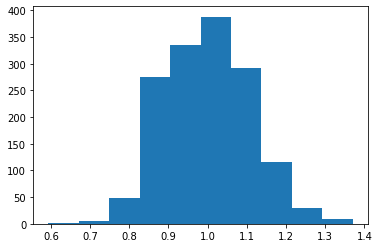

In [ ]:
# 8x8 digits dataset
M = 1500
N = 10
data_digits = sklearn.datasets.load_digits(n_class = N)
idx = np.random.choice(np.arange(data_digits.data.shape[0]), size = M)
data_digits.data = data_digits.data[idx]
data_digits.images = data_digits.images[idx]
data_digits.target = data_digits.target[idx]
target = data_digits.target

perm = np.random.permutation(M)
train_idx = perm[:750]
test_idx = perm[750:]

sizex, sizey = (8, 8)
X = tl.tensor([x for x in data_digits.images], dtype = tl_dtype)
X = X/X.sum(-1).sum(-1).mean()
plt.hist(X.sum(-1).sum(-1))

X_test = X[test_idx]
X_train = X[train_idx]

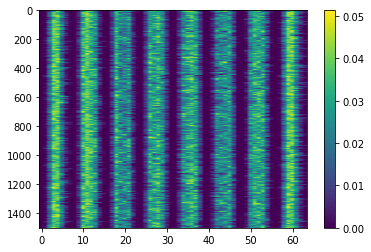

In [ ]:
plt.imshow(tl.unfold(X, 0))
plt.axis("auto")
plt.colorbar()

In [ ]:
xx, yy = np.meshgrid(range(sizex), range(sizey))
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

In [ ]:
# now pick multilinear rank
d = 3
r = [10, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

RAND_STATE = 0

# initialise using SVD
factor_cp = tl.decomposition.non_negative_parafac(X_train, rank = r[0], n_iter_max = 0, init = "svd", random_state = RAND_STATE)
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0_train = X_train.to(device)

###

# good params
# n_iter = 10
# lr = np.ones(n_iter)*0.1
# lamda = np.array([np.ones(3), ]*n_iter)*10
# optim_modes = [0, ]
# rho = np.array([np.array([1, 1, 1]), ]*n_iter)*0.01
# eps = np.array([np.ones(3), ]*n_iter)*0.01
n_iter = 10
lr = np.ones(n_iter)
lamda = np.array([np.ones(3), ]*n_iter)*25
optim_modes = [0, ]
rho = np.array([np.array([0.05/r[0], 0.05/r[0], 0.05/r[0]]), ]*n_iter)
eps = np.array([np.ones(3), ]*n_iter)*0.01

In [ ]:
max_iter, print_inter, check_iter, tol, unbal = (100, 10, 10, 1e-2, True)
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0_train, 0, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m0, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m0.U[0].max())
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_train, 1, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m1, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m1.U[0].max())
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0_train, 2, None, S, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
    wtf.solve(m2, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    print(m2.U[0].max())
    A[2] = m2.compute_primal_variable().detach()
    # print("Core tensor")
    # m = wtf.CoreModel(X0_train, None, A, rho[i, :], eps[i, :], lamda[i, :], optim_modes, ot_mode = "slice", C_full = C_full, device = device, unbal = unbal)
    # wtf.solve(m, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    # S = m.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 22.766610
i = 10 	 dual = 13.176609
i = 20 	 dual = 13.119162
tensor(1.0241, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 1
i = 0 	 dual = 27.278267
i = 10 	 dual = 17.050987
i = 20 	 dual = 15.772978
i = 30 	 dual = 15.634902
i = 40 	 dual = 15.560052
i = 50 	 dual = 15.526235
i = 60 	 dual = 15.511084
tensor(1.0130, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 2
i = 0 	 dual = 26.716416
i = 10 	 dual = 18.692883
i = 20 	 dual = 18.107549
i = 30 	 dual = 18.071580
i = 40 	 dual = 18.060866
tensor(0.6073, device='cuda:0', grad_fn=<MaxBackward1>)
Block iteration  1
Mode 0
i = 0 	 dual = 29.171166
i = 10 	 dual = 24.239900
i = 20 	 dual = 24.174448
tensor(0.8307, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 1
i = 0 	 dual = 28.034220
i = 10 	 dual = 22.707284
i = 20 	 dual = 22.529669
i = 30 	 dual = 22.500239
i = 40 	 dual = 22.483565
i = 50 	 dual = 22.471939
tensor(0.8469, device='cuda:0', grad_fn=<MaxBackward1>)
Mode 2
i = 0 	 dual = 28.205

In [ ]:
X_hat_train = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp_train = tl.decomposition.non_negative_parafac(X_train, rank = r[0], init = "svd", n_iter_max = 500, random_state = RAND_STATE, tol = 1e-12)
X_cp_train = tl.cp_tensor.cp_to_tensor(factor_cp_train)

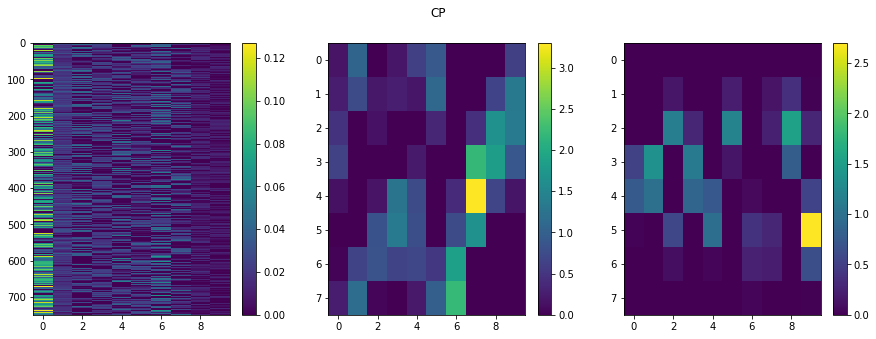

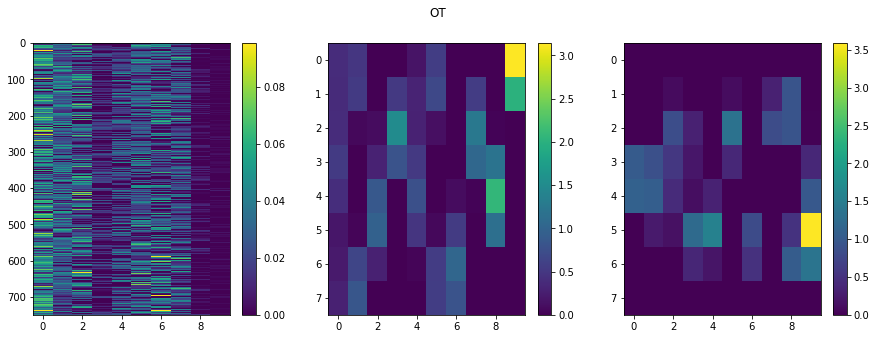

In [ ]:
plt.figure(figsize = (15, 5))
plt.suptitle("CP")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(factor_cp_train.factors[i], interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

plt.figure(figsize = (15, 5))
plt.suptitle("OT")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(A[i].cpu(), interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

(-0.5, 99.5, 9.5, -0.5)

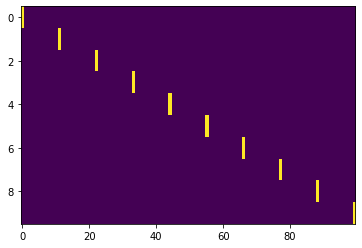

In [ ]:
plt.imshow(tl.unfold(S, 0).cpu())
plt.axis("auto")

(-0.5, 749.5, 63.5, -0.5)

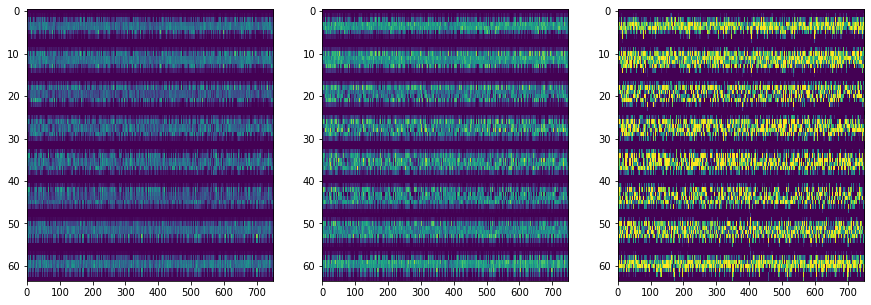

In [ ]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_hat_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 2)
plt.imshow(X_cp_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 3)
plt.imshow(X_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")

In [ ]:
d_ot = np.array([ot.emd2(wtf.normalise(X_hat_train[i, :, :].reshape(-1).double()), wtf.normalise(X_train[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])
d_baseline = np.array([ot.emd2(wtf.normalise(X_cp_train[i, :, :].reshape(-1).double()), wtf.normalise(X_train[i, :, :].reshape(-1).double()), C_full.cpu()) for i in range(X_train.shape[0])])

In [ ]:
d_ot.mean(), d_baseline.mean()

(0.014333499442609067, 0.018039589302238337)

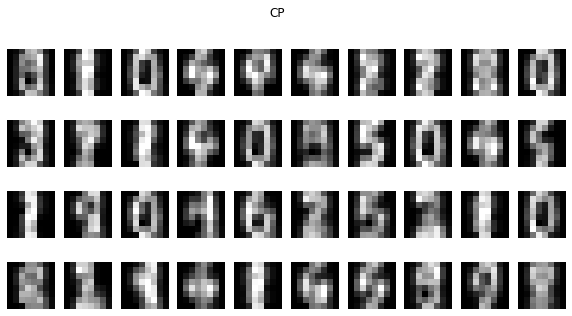

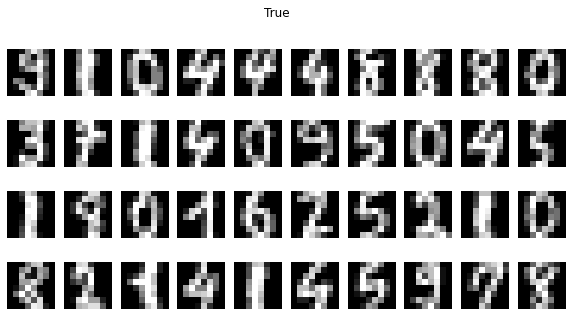

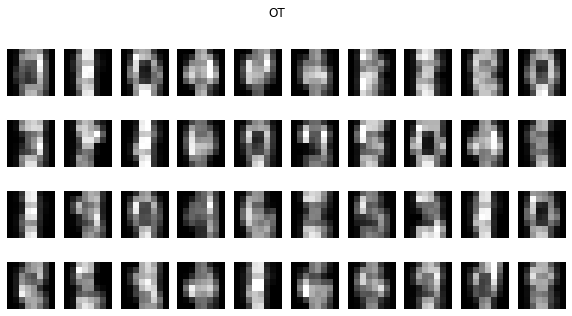

In [ ]:
vmax = np.quantile(X_train, 0.95)
perm = np.random.permutation(X_train.shape[0])

plt.figure(figsize = (10, 5))
plt.suptitle("CP")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_cp_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

plt.figure(figsize = (10, 5))
plt.suptitle("True")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

plt.figure(figsize = (10, 5))
plt.suptitle("OT")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_hat_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

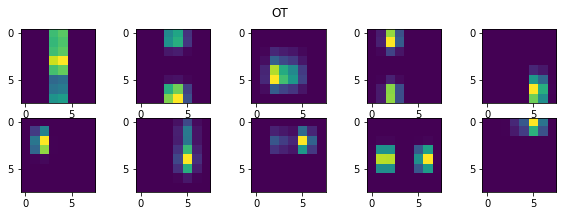

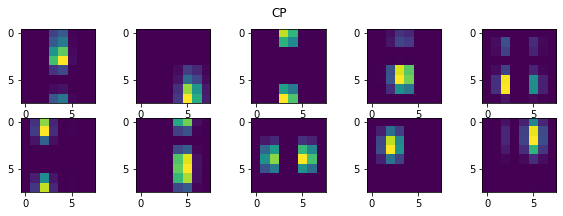

In [ ]:
def outer(u, v):
    return u.reshape(-1, 1) * v.reshape(1, -1)

plt.figure(figsize = (10, 3))
plt.suptitle("OT")
perm = np.array(np.argsort(A[0].sum(0).cpu()))[::-1]
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(outer(A[1][:, perm[i]], A[2][:, perm[i]]).cpu())

plt.figure(figsize = (10, 3))
plt.suptitle("CP")
perm = np.array(np.argsort(factor_cp_train.factors[0].sum(0)))[::-1]
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(outer(factor_cp_train.factors[1][:, perm[i]], factor_cp_train.factors[2][:, perm[i]]).cpu())

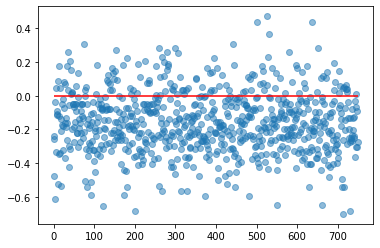

In [ ]:
plt.scatter(np.arange(d_ot.shape[0]), (d_ot - d_baseline)/d_baseline, alpha = 0.5)
plt.hlines(0, 0, d_ot.shape[0], color = "red")

In [ ]:
from sklearn import cluster
kmeans = sklearn.cluster.KMeans(n_clusters = 10, n_init = 25)
def get_nmi_avg(M):
    clust = kmeans.fit_predict(M)
    return sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust)

In [ ]:
nmi_ot = np.array([get_nmi_avg(A[0].cpu()) for _ in range(10)])
nmi_cp = np.array([get_nmi_avg(factor_cp_train.factors[0]) for _ in range(10)])
nmi_ot, nmi_cp

(array([0.53779899, 0.532917  , 0.53382592, 0.53632181, 0.5449761 ,
        0.52947555, 0.53484976, 0.54367121, 0.53462743, 0.54516112]),
 array([0.47645415, 0.47241036, 0.46894321, 0.47187952, 0.48320736,
        0.49010779, 0.48415006, 0.48533262, 0.46966394, 0.47730173]))

In [ ]:
nmi_ot.mean(), nmi_cp.mean()

(0.5373624874384605, 0.47794507428375094)

In [ ]:
# SVM classifier
from sklearn import svm
clf = svm.SVC()
clf.fit(A[0].cpu(), target[train_idx])

# fit new coefficients
A_test = [tl.ones((X_test.shape[0], r[0]), dtype = tl_dtype), tl.copy(A[1]), tl.copy(A[2])]
m0 = wtf.FactorsModel(tl.tensor(X_test, dtype = tl_dtype).cuda(), 0, None, S, A_test, rho[0, :], eps[0, :], lamda[0, :], 
                         optim_modes, ot_mode = "slice", U_init = None, C_full = C_full, device = device, unbal = unbal)
wtf.solve(m0, lr = lr[0], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = 1e-4)
A_test[0] = m0.compute_primal_variable().detach()

/usr/local/lib/python3.7/dist-packages/tensorly/backend/pytorch_backend.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)


i = 0 	 dual = 33.245282
i = 10 	 dual = 29.910402
i = 20 	 dual = 29.592265
i = 30 	 dual = 29.564593
i = 40 	 dual = 29.557863
i = 50 	 dual = 29.555022
i = 60 	 dual = 29.553208
i = 70 	 dual = 29.552139
i = 80 	 dual = 29.551317
i = 90 	 dual = 29.550762


In [ ]:
err_train = (clf.predict(A[0].cpu()) != target[train_idx]).mean() # train error
err_test = (clf.predict(A_test[0].cpu()) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.05466666666666667  err_test =  0.09466666666666666


In [ ]:
# SVM classifier for Frobenius-CP
clf_cp = svm.SVC()
clf_cp.fit(factor_cp_train.factors[0], target[train_idx])
cp_fitter = sklearn.decomposition.NMF()
cp_fitter.n_components_ = 10
cp_fitter.components_ = np.array(tl.tenalg.khatri_rao(factor_cp_train.factors[1:])).T
coeffs = cp_fitter.transform(tl.unfold(X_test, 0))
err_train = (clf_cp.predict(factor_cp_train.factors[0]) != target[train_idx]).mean() # train error
err_test = (clf_cp.predict(coeffs) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.06266666666666666  err_test =  0.08


In [ ]:
# SVM classifier for PCA
pca = sklearn.decomposition.PCA(n_components = 10)
X_train_pca = pca.fit_transform(tl.unfold(X_train, 0))
X_test_pca = pca.transform(tl.unfold(X_test, 0))
clf_pca = svm.SVC()
clf_pca.fit(X_train_pca, target[train_idx])
err_train = (clf_pca.predict(X_train_pca) != target[train_idx]).mean() # train error
err_test = (clf_pca.predict(X_test_pca) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.010666666666666666  err_test =  0.03866666666666667
